In [1]:
import os 
import sys
sys.path.append('/home/jessica/labelGAN/StyleGAN.pytorch/')
from models.GAN import * 
#from stylegan_layers import  G_mapping,G_synthesis
import torch
import matplotlib.patches as patches
from collections import OrderedDict
import torch.nn.functional as F
from sklearn.neighbors import KernelDensity
from torchvision.utils import save_image
from tqdm import tqdm
from PIL import Image, ImageOps
from torchvision import transforms
import torchvision
from torchvision import models
import cv2
import torch.nn as nn
from torchvision.utils import save_image
import pydicom as dicom
import numpy as np
from math import log10
import pandas as pd
import matplotlib.pyplot as plt
from model import * 
from utils import * 
import imageio
sys.path.append("/home/jessica/labelGAN/datasetGAN_release/models")
from stylegan1 import G_mapping,Truncation,G_synthesis


In [3]:
import torch 


In [5]:
import torch.nn as nn

# Define the input tensor
x = torch.randn(512, 16, 16)

# Define the upsample module
upsample = nn.Upsample(size=(512, 17, 17), mode='nearest')

# Upsample the input tensor
y = upsample(x)

# Verify the size of the output tensor
print(y.size())  # Output: torch.Size([512, 17, 17])

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [16] and output size of (512, 17, 17). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [2]:
df = pd.read_csv("vinbig_25_samples.csv")

In [3]:
df

Unnamed: 0                          image_id    class_name  class_id  \
0             1  21a10246a5ec7af151081d0cd6d65dc9    No finding        14   
1             4  063319de25ce7edb9b1c6b8881290140    No finding        14   
2            33  42d472bdda3ad93dac63c8e5e29977bb    No finding        14   
3            34  2b1293d9c276e5439e499f58ce2e31ab    No finding        14   
4            65  2561ba15f063a8e3a0322ad943738bb5    No finding        14   
..          ...                               ...           ...       ...   
370       14749  31ffa866e091965da25a408b4cc7d0db  Pneumothorax        12   
371       15725  0f45742c4d100eeee221f8853d79c9d4  Pneumothorax        12   
372       15862  3c63e58fcda26e02fdd6619515399985  Pneumothorax        12   
373       16769  393909c0d12d67fd08703d36970014e8  Pneumothorax        12   
374       19158  43cbc92d48a9318036e947277c3981fd  Pneumothorax        12   

    rad_id   x_min   y_min   x_max   y_max  
0       R7     NaN     NaN     NaN     NaN  
1      R10     NaN     NaN     NaN     NaN  
2       R9     NaN     NaN     NaN     NaN  
3       R8     NaN     NaN     NaN     NaN  
4       R2     NaN     NaN     NaN     NaN  
..     ...     ...     ...     ...     ...  
370     R9  1212.0   355.0  1868.0  1192.0  
371    R10   308.0  1511.0   430.0  1669.0  
372     R9   226.0   340.0   950.0  1327.0  
373    R10  1817.0   515.0  2249.0  1485.0  
374     R8  1254.0   517.0  1696.0   677.0  

[375 rows x 9 columns]

In [3]:
p = '/data3/jessica/data/labelGAN/vinbig/train/'
images = {}
for image_id in df[df.class_name != 'No finding'].image_id:
    path = p + image_id + ".dicom"
    ds = dicom.dcmread(path)
    images[image_id] = ds.pixel_array.astype('float32')/np.max(ds.pixel_array)

/home/jessica/.local/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/home/jessica/.local/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


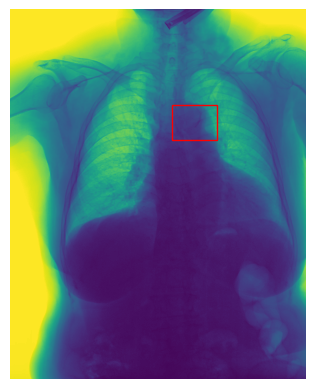

In [ ]:
for key in list(images.keys()):
    id_test = images[key]
    fil_elem = df[df.image_id == id_test].iloc[0]
    xmin, ymin, xmax, ymax = fil_elem.x_min, fil_elem.y_min, fil_elem.x_max, fil_elem.y_max
    fig, ax = plt.subplots(frameon=False)
    ax.set_axis_off()
    # Display the image
    ax.imshow(images[id_test])

    # Create a Rectangle patch
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    fig.savefig("./labeling_help/" + id_test, bbox_inches='tight')

    #plt.show()

In [3]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
g_all = nn.Sequential(OrderedDict([('g_mapping', G_mapping()),
    #('truncation', Truncation(avg_latent)),
    ('g_synthesis', G_synthesis(resolution=1024))    
    ]))

opts = {'mapping_layers': 8, 'truncation_psi': -1.}
'''g_all = Generator(resolution=1024,
                    num_channels=3,
                    structure='linear',
                    **opts)'''
g_all = nn.Sequential(OrderedDict([('g_mapping', GMapping()),
    #('truncation', Truncation(avg_latent)),
    ('g_synthesis', GSynthesis(resolution=1024, depth=8))    
    ]))
#Load the pre-trained model
g_all.load_state_dict(torch.load('/data1/jessica/data/labelGAN/checkpoints/styleGAN/GAN_GEN_8.pth', map_location=device), strict=False)
g_all.eval()
g_all.to(device)
g_mapping, g_synthesis = g_all[0], g_all[1]
perceptual = VGG16_perceptual().to(device)

/home/jessica/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jessica/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def get_latents(images, procedure="hierarchical"):
    tbi = ['Lung Opacity', 'Infiltration', 'Atelectasis', 'Pleural thickening']
    latents = {}
    for image_class in images.keys():
        image = images[image_class].astype(float)
        if len(image.shape) == 2:
            image = np.stack((image,)*3, axis=-1)
        #if image_class + ".png" in os.listdir('/home/jessica/labelGAN/Image2StyleGAN/images/invert') or image_class + ".png" in os.listdir('/home/jessica/labelGAN/Image2StyleGAN/images/curated'): continue
        #if image_class in tbi: image = 1-image
        plt.imshow(image)
        plt.savefig('./images/' + image_class + '.png')
        image = torch.tensor(image).float().unsqueeze(0).permute(0,-1,1,2).to(device)
        latent = embedding_function(image, perceptual, g_synthesis, device, image_class) if procedure!="hierarchical" else embedding_Hierarchical(image, perceptual, g_synthesis, device)
        latents[image_class] = latent
    return latents

KeyboardInterrupt: 

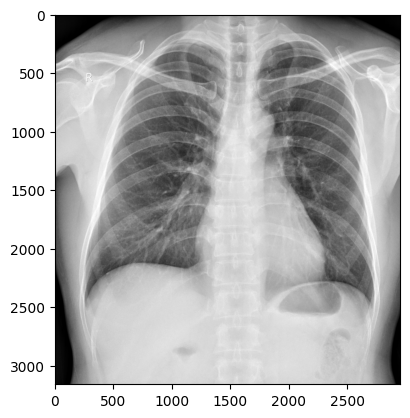

In [8]:
latents_hierarchial = get_latents(images, procedure="normal")

In [19]:
len(images.keys())

103

In [16]:
latents_hierarchial

{}

In [ ]:
ims_invert = ['2561ba15f063a8e3a0322ad943738bb5', '389526ec796c3955a9a89a66f04bc247']

In [3]:
p = '/data1/jessica/data/labelGAN/imgs_new_diseases_vinbig/'
image_path = lambda i: f'{p}{i}'
images = {}
for elem in os.listdir(p):
    if "Store" in elem or "._" in elem: continue
    path = image_path(elem)
    ds = dicom.dcmread(path)
    NAME = elem.replace(".dicom", "")   
    images[(NAME, few_shot_classes[NAME])] = ds.pixel_array.astype('float32')/np.max(ds.pixel_array)

/home/jessica/.local/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


In [6]:
path = '/data1/jessica/data/labelGAN/nih_data/train/person1207_bacteria_3159.jpeg'
image = read_image(path, device)
images["Bacteria"] = image.permute(0,2,3,1).cpu().numpy()[0]

In [7]:
#Read a sample image we want to find a latent vector for
# IMages : Portrait00002.png
img_path = '/data1/jessica/data/labelGAN/nih_data/test/NORMAL/NORMAL2-IM-0252-0001.jpeg'
image = read_image(img_path, device)
images["No finding"] = image.permute(0,2,3,1).cpu().numpy()[0]
#plt.imshow(images["No finding"])

In [9]:
tbi = ['Lung Opacity', 'Infiltration', 'Atelectasis', 'Pleural thickening']

for key in images.keys():
    print(key)
    img = images[key].astype(float)
    name = key.replace("/", "").replace(" ", "")
    if len(img.shape) == 2:
        img = np.stack((img,)*3, axis=-1)
    if key in tbi: image = 1-image
    plt.imshow(img)
    plt.savefig(f"./save_image/{name}.png")
    break

Other lesion


##Image Morphing Experiment

In [57]:
def save_images_from_latent(latent1, latent2, name, path):
  name = name.replace(" ", "").replace("/", "")
  print(path, name)
  r = 10
  ig, axs = plt.subplots(nrows=1, ncols=r, figsize=(64,28))
  for i in range(r):
    a = (1/r)*i
    w = latent1 * (1-a)+ latent2 * a
    syn_img = g_synthesis(w, depth=8)
    syn_img = (syn_img+1.0)/2.0
    ax = axs.flatten()[i]
    plt.sca(ax)
    plt.imshow(syn_img.clamp(0,1).permute(0,2,3,1)[0].cpu().detach().numpy())
    plt.tick_params(left = False, right=False, bottom = False)
    plt.xticks([])
    plt.yticks([])
  plt.savefig(f"{path}/{name}_hier.png")

save_image/test Bacteria


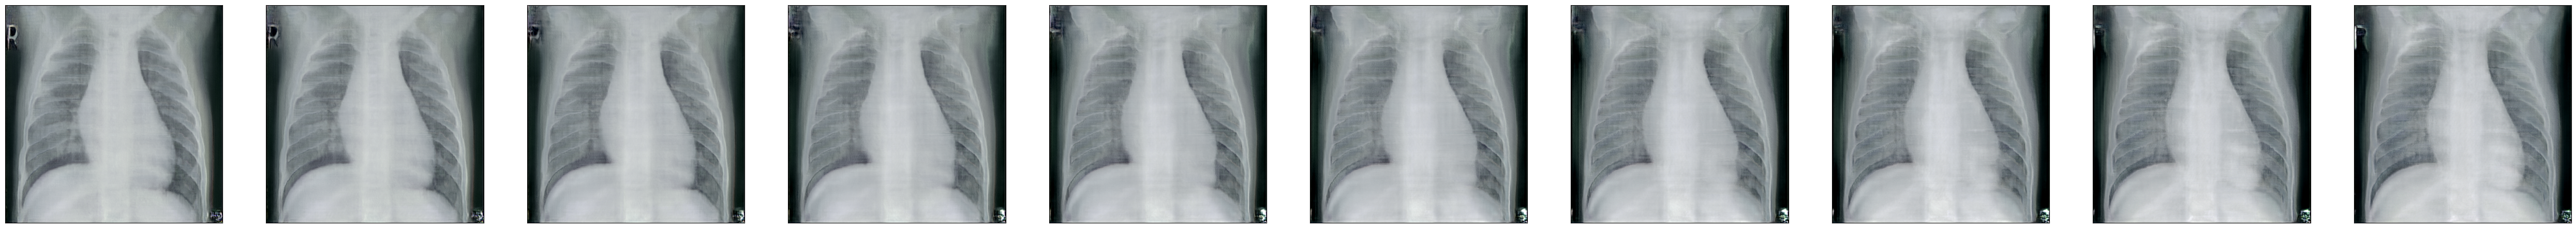

In [58]:
for elem in latents_hierarchial.keys():
    if elem == 'No finding': continue
    latent1 = latents_hierarchial['No finding']
    latent2 = latents_hierarchial[elem]
    if elem != "Bacteria": continue
    save_images_from_latent(latent1, latent2, elem, path='save_image/test')
    break

In [96]:
import altair as alt
import numpy as np 
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from numpy.linalg import norm

In [101]:
def vis_tsne(elems, clusters=None):
    elems = elems.squeeze()
    elems = elems.reshape(elems.shape[0], -1)
    print(elems.shape)
    tsne = TSNE(n_components=2, verbose=1, perplexity=5, random_state=123)
    #tsn = lambda X: tsne(X)
    z = tsne.fit_transform(elems) 
    #z = tsn(elems)
    df = pd.DataFrame()
    
    df["comp1"] = z[:,0]
    df["comp2"] = z[:,1]
    df['index'] = df.index
    if clusters == None:
        return df
    elif clusters.all() != None:
        df['clusters'] = clusters
    return df

In [113]:
samples = []
for i, elem in enumerate(latents_hierarchial.keys()):
    mu = latents_hierarchial[elem].cpu().detach().numpy()[0].reshape(-1)
    sigma = np.identity(mu.shape[0])
    sample = np.random.multivariate_normal(mu, sigma, 1000)
    samples.extend(sample)

(9216,)


In [102]:
elems_to_map = samples#[latents_hierarchial[key].cpu().detach().numpy() for key in latents_hierarchial.keys()]
df = vis_tsne(np.array(elems_to_map))

(16, 9216)
[t-SNE] Computing 15 nearest neighbors...
[t-SNE] Indexed 16 samples in 0.000s...
[t-SNE] Computed neighbors for 16 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 16 / 16
[t-SNE] Mean sigma: 17.132043
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.470108


/home/jessica/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jessica/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.322924


In [103]:
alt.Chart(df).mark_circle(size=60).encode(
    x='comp1',
    y='comp2',
    #color='clusters',
    tooltip=['index']
).interactive()

alt.Chart(...)

##Obtaining latent codes for 2 images using Hierarchical Optimisation to check Image Morphing

ss torch.Size([1, 3, 1024, 1024])
f torch.Size([1, 3, 256, 256])
torch.Size([1, 64, 256, 256]) torch.Size([1, 64, 256, 256]) torch.Size([1, 256, 64, 64]) torch.Size([1, 512, 32, 32])
dd torch.Size([1, 64, 256, 256]) torch.Size([1, 64, 256, 256]) torch.Size([1, 256, 64, 64]) torch.Size([1, 512, 32, 32])
torch.Size([1, 3, 1024, 1024]) torch.Size([1, 3, 1024, 1024])
ss torch.Size([1, 3, 1024, 1024])
f torch.Size([1, 3, 256, 256])
torch.Size([1, 64, 256, 256]) torch.Size([1, 64, 256, 256]) torch.Size([1, 256, 64, 64]) torch.Size([1, 512, 32, 32])
dd torch.Size([1, 64, 256, 256]) torch.Size([1, 64, 256, 256]) torch.Size([1, 256, 64, 64]) torch.Size([1, 512, 32, 32])
torch.Size([1, 3, 1024, 1024]) torch.Size([1, 3, 1024, 1024])
ss torch.Size([1, 3, 1024, 1024])
f torch.Size([1, 3, 256, 256])
torch.Size([1, 64, 256, 256]) torch.Size([1, 64, 256, 256]) torch.Size([1, 256, 64, 64]) torch.Size([1, 512, 32, 32])
dd torch.Size([1, 64, 256, 256]) torch.Size([1, 64, 256, 256]) torch.Size([1, 256, 64

/tmp/ipykernel_3384917/2978322456.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_w1 = torch.tensor(latent_w1, requires_grad=True)


ss torch.Size([1, 3, 1024, 1024])
f torch.Size([1, 3, 256, 256])
torch.Size([1, 64, 256, 256]) torch.Size([1, 64, 256, 256]) torch.Size([1, 256, 64, 64]) torch.Size([1, 512, 32, 32])
dd torch.Size([1, 64, 256, 256]) torch.Size([1, 64, 256, 256]) torch.Size([1, 256, 64, 64]) torch.Size([1, 512, 32, 32])
torch.Size([1, 3, 1024, 1024]) torch.Size([1, 3, 1024, 1024])
ss torch.Size([1, 3, 1024, 1024])
f torch.Size([1, 3, 256, 256])
torch.Size([1, 64, 256, 256]) torch.Size([1, 64, 256, 256]) torch.Size([1, 256, 64, 64]) torch.Size([1, 512, 32, 32])
dd torch.Size([1, 64, 256, 256]) torch.Size([1, 64, 256, 256]) torch.Size([1, 256, 64, 64]) torch.Size([1, 512, 32, 32])
torch.Size([1, 3, 1024, 1024]) torch.Size([1, 3, 1024, 1024])
ss torch.Size([1, 3, 1024, 1024])
f torch.Size([1, 3, 256, 256])
torch.Size([1, 64, 256, 256]) torch.Size([1, 64, 256, 256]) torch.Size([1, 256, 64, 64]) torch.Size([1, 512, 32, 32])
dd torch.Size([1, 64, 256, 256]) torch.Size([1, 64, 256, 256]) torch.Size([1, 256, 64

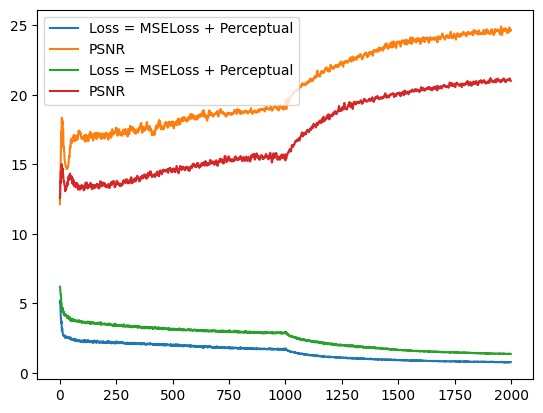

In [29]:
latent1 = embedding_Hierarchical(image)
latent2 = embedding_Hierarchical(image1)

In [32]:
#Image Morphing Experiment
for i in range(20):
  a = (1/20)*i
  w = latent2 * (1-a)+ latent1 * a
  syn_img = g_synthesis(w, depth=8)
  syn_img = (syn_img+1.0)/2.0
  save_image(syn_img.clamp(0,1),"./save_image/encode/Hier-Morphed{}.png".format(i))

Downsamplimg to use a deeper network as it reduces computational cost as well as to increase receptive field. As downsampled image each pixel in it will have a wider receptive area it will affect in the actual higher dimensional image.

Instead of pixel wise similarity we push for similarity in feature representations of real and synthesized images.

Downsample to match the input size expectation of VGG - 256 or 224

Taken Perceptual loss online official implementation

We dont need the mapping part of the StyleGAN but only synthesis part which expects input as 1 x 18 x 512 i.e, 18 w's each input into the layers of Synthesis part.

In [1]:
import pandas as pd

In [29]:
train = pd.read_csv("./train.csv", dtype={'image_id': 'str'})

In [73]:
lsdr = os.listdir("/data3/jessica/data/labelGAN/vinbig/train")

In [81]:
mask = train['image_id'].apply(lambda x: (x + ".dicom") in lsdr)
maskeddf = train[mask]

In [82]:
newdf = pd.DataFrame()
for elem in maskeddf.class_name.unique():
    n = maskeddf[maskeddf.class_name == elem][0:25]
    newdf = pd.concat((newdf,n))

In [83]:
newdf.shape

(375, 8)

In [85]:
newdf.to_csv("vinbig_25_samples.csv")

In [84]:
newdf


image_id    class_name  class_id rad_id  \
1      21a10246a5ec7af151081d0cd6d65dc9    No finding        14     R7   
4      063319de25ce7edb9b1c6b8881290140    No finding        14    R10   
33     42d472bdda3ad93dac63c8e5e29977bb    No finding        14     R9   
34     2b1293d9c276e5439e499f58ce2e31ab    No finding        14     R8   
65     2561ba15f063a8e3a0322ad943738bb5    No finding        14     R2   
...                                 ...           ...       ...    ...   
14749  31ffa866e091965da25a408b4cc7d0db  Pneumothorax        12     R9   
15725  0f45742c4d100eeee221f8853d79c9d4  Pneumothorax        12    R10   
15862  3c63e58fcda26e02fdd6619515399985  Pneumothorax        12     R9   
16769  393909c0d12d67fd08703d36970014e8  Pneumothorax        12    R10   
19158  43cbc92d48a9318036e947277c3981fd  Pneumothorax        12     R8   

        x_min   y_min   x_max   y_max  
1         NaN     NaN     NaN     NaN  
4         NaN     NaN     NaN     NaN  
33        NaN     NaN     NaN     NaN  
34        NaN     NaN     NaN     NaN  
65        NaN     NaN     NaN     NaN  
...       ...     ...     ...     ...  
14749  1212.0   355.0  1868.0  1192.0  
15725   308.0  1511.0   430.0  1669.0  
15862   226.0   340.0   950.0  1327.0  
16769  1817.0   515.0  2249.0  1485.0  
19158  1254.0   517.0  1696.0   677.0  

[375 rows x 8 columns]

In [1]:
import torch

In [2]:
a = torch.randn((3,1024*1024, 5088))

In [ ]:
a.shape

In [ ]:
a.reshape((3, 1024, 1024, 5088))

In [4]:
x1 = torch.randn(1, 512, 4, 4)
x2 = torch.randn(1, 256, 8, 8)

# Transposed convolution layer to upsample the first input to 8x8x512
upsample1 = torch.nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)

# Apply the transposed convolution to the first input
y1 = upsample1(x1)

# Pad the second input with zeros to match the spatial dimensions of the first input
pad = torch.nn.ZeroPad2d((0, 0, 2, 2, 2, 2))
x2_padded = pad(x2)

# Transposed convolution layer to upsample the second input to 8x8x512
upsample2 = torch.nn.ConvTranspose2d(256, 512, kernel_size=4, stride=4)

# Apply the transposed convolution to the padded second input
#y2 = upsample2(x2_padded)

# Concatenate the upsampled feature maps along the channel dimension##
#y = torch.cat((y1, y2), dim=1)

# Output tensor of size 1x1024x8x8
print(y1.shape)

torch.Size([1, 512, 8, 8])


In [7]:
x1 = torch.randn(1, 256, 64, 64)
x2 = torch.randn(1, 128, 128, 128)

# Resize x2 to 64x64 using bilinear interpolation
resize = torch.nn.Upsample(size=(64, 64), mode='bilinear')
x2_resized = resize(x2)

# Reduce the number of channels in x2_resized to 256
conv1x1 = torch.nn.Conv2d(128, 256, kernel_size=1)
x2_reduced = conv1x1(x2_resized)

In [9]:
x2_reduced.shape, x2_resized.shape


(torch.Size([1, 256, 64, 64]), torch.Size([1, 128, 64, 64]))

In [10]:
import torch

# Input tensors with different spatial dimensions and channel counts
x1 = torch.randn(1, 256, 64, 64)
x2 = torch.randn(1, 128, 128, 128)

# Resize x2 to 64x64 using bilinear interpolation
resize = torch.nn.Upsample(size=(64, 64), mode='bilinear')
x2_resized = resize(x2)

# Reduce the number of channels in x1 to 128
conv1x1 = torch.nn.Conv2d(256, 128, kernel_size=1)
x1_reduced = conv1x1(x1)

# Output tensor of size 1x128x64x64
print(x1_reduced.shape)
print(x2_resized.shape)

torch.Size([1, 128, 64, 64])
torch.Size([1, 128, 64, 64])
